# Imports

In [1]:
import scipy.io
from google.colab import drive
import numpy as np
import matplotlib.pyplot as plt
import os
from PIL import Image
import torch
from torch.utils.data import Dataset
from torchvision import transforms
import copy

from scipy import ndimage as ndi
from skimage.segmentation import watershed
from skimage.feature import peak_local_max
from skimage.filters import threshold_otsu
from skimage import data

In [2]:
# This will prompt for authorization.
drive.mount('/content/drive')

# After executing the cell above, Drive
# files will be present in "/content/drive/My Drive".
!ls "/content/drive/My Drive/magisterka22/dane"

Mounted at /content/drive
HFD2tyg_N01_T1maps.mat	HighFatDiett  Kontrolaa  Version0  Version1


In [3]:
DATA_DIR = '/content/drive/My Drive/magisterka22/dane/Version1/Train/'
OUT_DIR = '/content/drive/My Drive/magisterka22/dane/SelectedHeart/Train/'

FAT_DIR = DATA_DIR + 'Square/HighFatDiet'
HEALTHY_DIR = DATA_DIR + 'Square/Kontrola'
FAT_DIR1 = DATA_DIR + 'Rectangle/HighFatDiet'
HEALTHY_DIR1 = DATA_DIR + 'Rectangle/Kontrola'

OUT_FAT_DIR = OUT_DIR + 'Square/HighFatDiet'
OUT_HEALTHY_DIR = OUT_DIR + 'Square/Kontrola'
OUT_FAT_DIR1 = OUT_DIR + 'Rectangle/HighFatDiet'
OUT_HEALTHY_DIR1 = OUT_DIR + 'Rectangle/Kontrola'



# Utils

In [4]:
def fix_image(im, min_size=192): #it shold be do one and decide the dirrection
  (x, y) = im.shape
  #print("before fix x:",x," y:", y)
  if x < min_size:
    im = np.concatenate((im, np.zeros((min_size-x, y))))
  (x, y) = im.shape
  #print("after first fix x:",x," y:", y)
  if y < min_size:
    im = np.concatenate((im, np.zeros((x, min_size-y))), axis=1)
  return im

def load_image(filepath, label, pre = False, rgb = False):
  maps = scipy.io.loadmat(filepath)
  #print(maps.keys())
  img_pre = np.array(maps['preT1map'], np.double)
  img_pre = fix_image(img_pre)
  img_post = np.array(maps['postT1map'], np.double)
  img_post = fix_image(img_post)
  if rgb:
    img_pre = toRGB(img_pre)
    img_post = toRGB(img_post)
  if pre:
    return (img_pre, label)
  return (img_post, label)

def toRGB(image):
  #image = image/2500
  rgb_image = np.stack((image, image, image), axis=2)
  return rgb_image

# Data

In [5]:
class PyTorchImageDataset(Dataset):
    def __init__(self, fat_dir, healthy_dir, transforms=None, rgb=False):
        fat = [load_image(os.path.join(fat_dir, filename), 1, True, rgb) for filename in os.listdir(fat_dir)]
        healthy = [load_image(os.path.join(healthy_dir, filename), 0, True, rgb) for filename in os.listdir(healthy_dir)]
        all = np.array(fat + healthy)
        np.random.shuffle(all)
        self.image_list = [x[0] for x in all]
        self.labels = [x[1] for x in all]
        self.transforms = transforms
         
    def __len__(self):
        return (len(self.image_list))
    
    def __getitem__(self, i):
        image = self.image_list[i]    
        image = np.array(image/10).astype(np.uint8) #TODO when rgb
        #image = np.array(image).astype(np.float32)
        if self.transforms is not None:
            image = self.transforms(image) 
        #image = image/2500 
        return (torch.tensor(image, dtype=torch.float), self.labels[i])

In [6]:
#load data
rgb = True

resnet_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.ToTensor(),
])

dataset = PyTorchImageDataset(FAT_DIR, HEALTHY_DIR, resnet_transform, rgb)
print("Train dataset size:", len(dataset))

print("item shape", dataset.image_list[0].shape, " label", dataset.labels[0])

Train dataset size: 24
item shape (192, 192, 3)  label 0


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  """


NORMAL shape: (3, 192, 192) min: 0.0  max: 2488.6166200882185


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  """


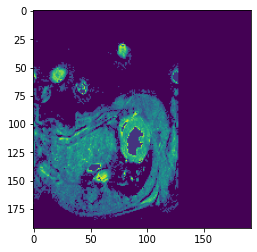

In [ ]:
#save as jpg

rgb = True

resnet_transform = transforms.Compose([
    transforms.ToPILImage(),
    #transforms.ToTensor(),
])

dataset_for_jpg = PyTorchImageDataset(FAT_DIR, HEALTHY_DIR, resnet_transform, rgb)

img = dataset_for_jpg.image_list[10]
img = img.transpose((-1, 0, 1))
print("NORMAL shape:", img.shape, "min:", np.min(img), " max:", np.max(img))
img = img[0]
plt.imshow(img)
plt.show()
im = Image.fromarray(img).convert('L')
im.save("your_file.jpeg")

In [17]:
def prep_mask(x, y, mask=np.zeros((192,192))):
  for i in range(5):
    mask[x-i][y] = 1000
    mask[x+i][y] = 1000
    mask[x][y-i] = 1000
    mask[x][y+i] = 1000
  return mask

def visualize_cords(cords, mask= np.zeros((192,192))):
  for x,y in cords:
    mask = prep_mask(x,y,mask)
  return mask

def cat_from_img(img, out_size, x, y):
  return img[x:(x+out_size), y:(y+out_size)]

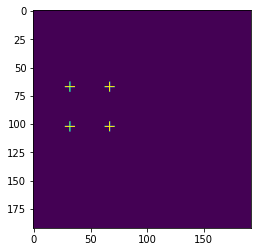

NORMAL shape: (192, 192, 3) min: 0  max: 249


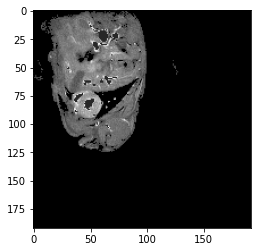

NORMAL shape: (3, 192, 192) min: 0  max: 249


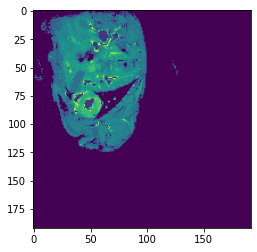

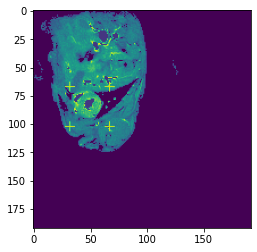

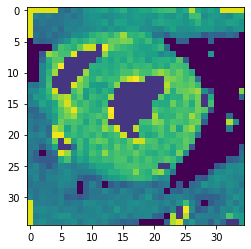

In [18]:
def prep_mask(x, y, mask=np.zeros((192,192))):
  for i in range(5):
    mask[x-i][y] = 1000
    mask[x+i][y] = 1000
    mask[x][y-i] = 1000
    mask[x][y+i] = 1000
  return mask

def visualize_cords(cords, mask= np.zeros((192,192))):
  for x,y in cords:
    mask = prep_mask(x,y,mask)
  return mask

fsize = 35
x = 67
y = 32
cords = [[x+fsize,y], [x+fsize,y+fsize], [x,y+fsize], [x,y]]
visualized_cords = visualize_cords(cords)
plt.imshow(visualized_cords)
plt.show()

img = dataset.image_list[10]
#img = img/2500
img = np.array(img/10).astype(np.uint8)
print("NORMAL shape:", img.shape, "min:", np.min(img), " max:", np.max(img))
plt.imshow(img)
plt.show()

img = img.transpose((-1, 0, 1))
print("NORMAL shape:", img.shape, "min:", np.min(img), " max:", np.max(img))
img = img[0]
plt.imshow(img)
plt.show()

img_with_cords = visualize_cords(cords, img)
plt.imshow(img_with_cords)
plt.show()

cutted_image = cat_from_img(img, fsize, x, y)
plt.imshow(cutted_image)
plt.show()

img sh: (192, 192) distance sh: (192, 192)


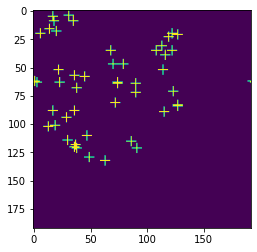

/usr/local/lib/python3.7/dist-packages/matplotlib/image.py:455: RuntimeWarning: overflow encountered in double_scalars
  newmin = vmid - dv * fact
/usr/local/lib/python3.7/dist-packages/matplotlib/image.py:460: RuntimeWarning: overflow encountered in double_scalars
  newmax = vmid + dv * fact
/usr/local/lib/python3.7/dist-packages/matplotlib/image.py:488: RuntimeWarning: invalid value encountered in multiply
  A_resampled *= ((a_max - a_min) / 0.8)


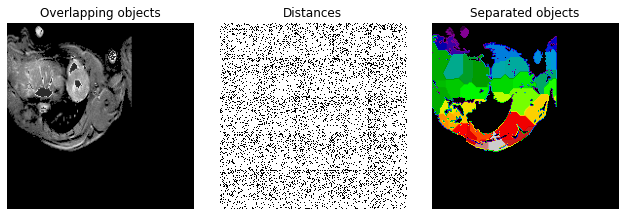

In [ ]:
distance = ndi.distance_transform_edt(img)
print("img sh:", img.shape, "distance sh:", distance.shape)
coords = peak_local_max(distance, footprint=np.ones((10, 10)), labels=img)
coords2 = peak_local_max(distance, footprint=np.ones((3, 3)), labels=img)
#coords = np.array([[71,69], [5,5]])
#print("coords:", coords)
visualized_cords = visualize_cords(coords)
plt.imshow(visualized_cords)
plt.show()

mask = np.zeros(distance.shape, dtype=bool)
mask[tuple(coords.T)] = True
markers, _ = ndi.label(mask)
labels = watershed(-distance, markers, mask=img)

fig, axes = plt.subplots(ncols=3, figsize=(9, 3), sharex=True, sharey=True)
ax = axes.ravel()

ax[0].imshow(img, cmap=plt.cm.gray)
ax[0].set_title('Overlapping objects')
ax[1].imshow(-distance, cmap=plt.cm.gray)
ax[1].set_title('Distances')
ax[2].imshow(labels, cmap=plt.cm.nipy_spectral)
ax[2].set_title('Separated objects')

for a in ax:
    a.set_axis_off()

fig.tight_layout()
plt.show()

In [ ]:
import cv2
import imutils

# find contours in the thresholded image
cnts = cv2.findContours(img.copy(), cv2.RETR_EXTERNAL,
	cv2.CHAIN_APPROX_SIMPLE)
cnts = imutils.grab_contours(cnts)
print("[INFO] {} unique contours found".format(len(cnts)))
# loop over the contours
for (i, c) in enumerate(cnts):
	# draw the contour
	((x, y), _) = cv2.minEnclosingCircle(c)
	#cv2.putText(img, "#{}".format(i + 1), (int(x) - 10, int(y)), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 0, 255), 2)
	cv2.drawContours(img, [c], -1, (0, 255, 0), 2)
# show the output image
cv2.imshow("Image", img)
cv2.waitKey(0)

[INFO] 19 unique contours found


error: ignored

# otsu


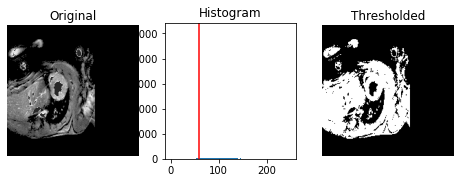

In [ ]:
image = img
thresh = threshold_otsu(image)
binary = image > thresh

fig, axes = plt.subplots(ncols=3, figsize=(8, 2.5))
ax = axes.ravel()
ax[0] = plt.subplot(1, 3, 1)
ax[1] = plt.subplot(1, 3, 2)
ax[2] = plt.subplot(1, 3, 3, sharex=ax[0], sharey=ax[0])

ax[0].imshow(image, cmap=plt.cm.gray)
ax[0].set_title('Original')
ax[0].axis('off')

ax[1].hist(image.ravel(), bins=256)
ax[1].set_title('Histogram')
ax[1].axvline(thresh, color='r')

ax[2].imshow(binary, cmap=plt.cm.gray)
ax[2].set_title('Thresholded')
ax[2].axis('off')

plt.show()

/usr/local/lib/python3.7/dist-packages/skimage/filters/thresholding.py:701: RuntimeWarning: divide by zero encountered in log
  (np.log(mean_back) - np.log(mean_fore)))


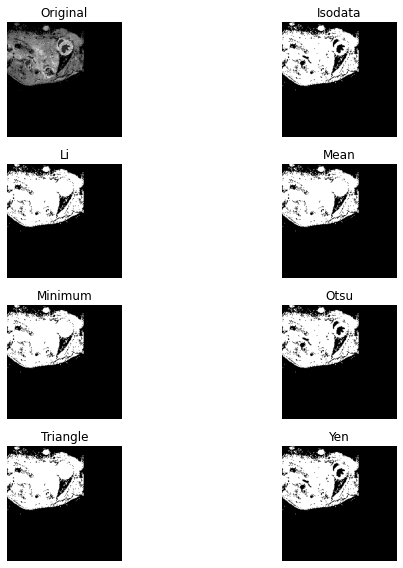

In [ ]:
from skimage.filters import try_all_threshold

fig, ax = try_all_threshold(img, figsize=(10, 8), verbose=False)
plt.show()